# Avazu CTR Outlier Detection Challenge

This notebook contains a solution for the Outlier Detection challenge on the Avazu Dataset for CTR prediction. Finding outliers is an important task in time series analysis, because "the presence of those extraordinary events could easily mislead the conventional time series analysis procedure resulting in erroneous conclusions" (Tsay, 1987). Apart from its use in better model selection, there are other uses of outliers. In this particular problem outliers can be used to inform business users when did their advertisement achieved particularly high or low click through rates. 

## 1. Data Preprocessing/Aggregation

Here I assume that the dataset is formatted using a comma separator and without double quotes around values. To confirm my assumption I've used linux data processing tools which is handy, because I did not have to load Python or the entire dataset into memory to do that. Example:
> zcat data/train.gz | head -n 10

I will use the pandas Python package for both the aggregation and the outlier detection. It is the de facto structured data processing tool for Python with lots of convenient function for data reading and manipulation. For example I can restrict the read columns and specify the date format aprior - both features will be used here. For the latter I will use a named function instead of a lambda function for a bit of speed up on the data processing.

It can happen sometime that a structured dataset has missing values, therefore it is safe to check first that all imported columns are complete - in this case the click column and hour in the index.

This dataset is a log of click events - clicks advertisements. Every row in the click column has a value of 1 or 0, where the latter signifies a non-click event. Click Through Rate (or CTR for short) is a common measure to quantify the success of an online advertisement and it is calculated by dividing the number of clicks with the number of impressions in a given timeframe. The CTR calculation is defined as a named function to avoid some of the high latency commonly attributed to lambda functions.

The entire data processing is wrapped in a function for one good reason: after the interpreter leaves this function and returns the aggregated data, there will be no more references to the log data and will be garbage collected, thus potentially freeing up a large amount of memory.

In [1]:
from datetime import datetime

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


def date_parser_func(date_str):
    return datetime.strptime(date_str, '%y%m%d%H')


def calc_ctr(group):
    return group.sum() / group.count()


def read_and_process_events(path):

    # data reading and preprocessing
    events = pd.read_csv(
        path, sep=',', usecols=['click', 'hour'], index_col='hour',
        parse_dates=['hour'], date_parser=date_parser_func,
        dtype={'click': np.int8}, compression='gzip'
    )

    # missing data check
    assert (events['click'].isnull().sum() == 0) & (events.index.isnull().sum() == 0)

    # aggregation
    ctr = events['click'].groupby(pd.Grouper(freq='H')).agg(calc_ctr)
    ctr.rename(columns={'click': 'ctr'}, inplace=True)

    # check for invalid data
    assert ((ctr >= 0.0) & (ctr <= 1.0)).all()

    return ctr

The simplest way to confirm that the data processing was successful is to plot the result of the read_and_process_events function, see below. It is expected that the plotted line (representing CTR) is continuous. However it could've happened that there would not have been any impressions during a certain hour - maybe due to a system downtime - in which case the spots would've been needed to be filled or an appropriate model would've been needed later that can handle irregular time series.

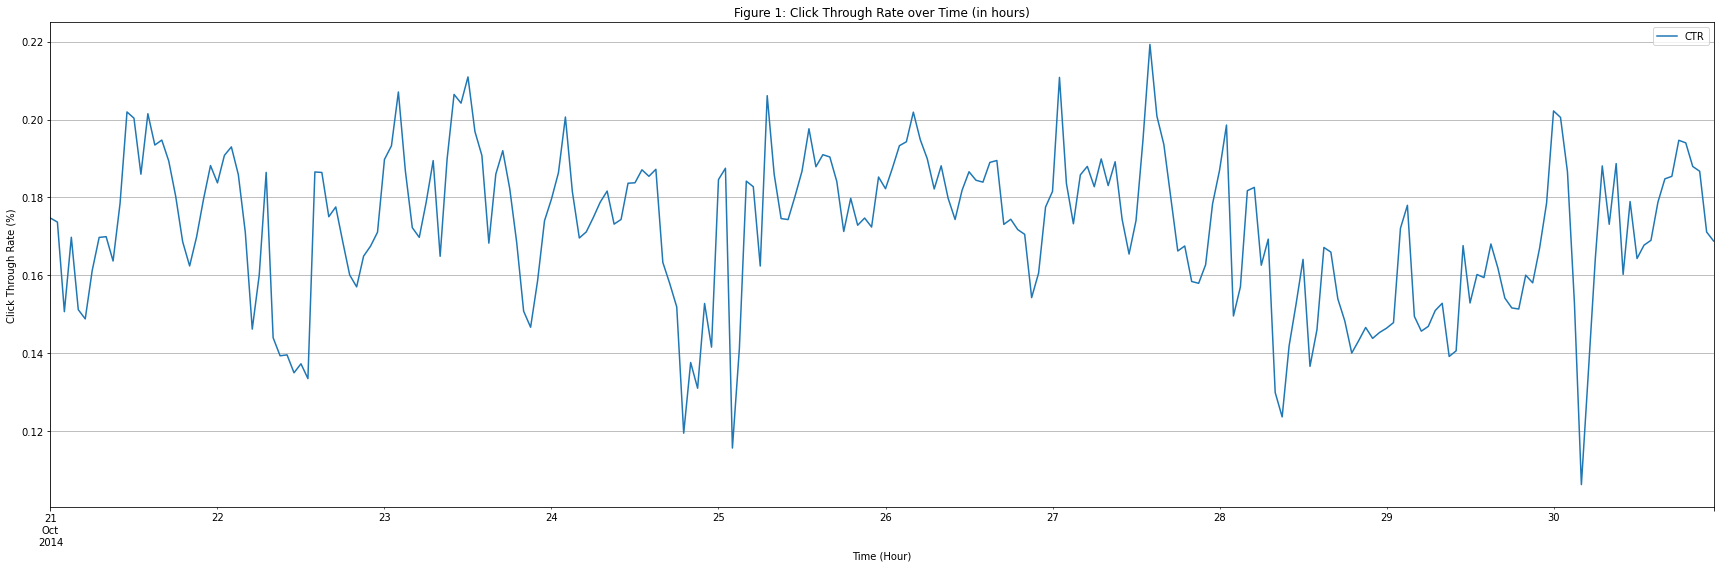

In [2]:
# loading the training dataset
train_ctr = read_and_process_events('data/train.gz')

# visualization
train_ctr.plot(kind='line', title='Figure 1: Click Through Rate over Time (in hours)', grid=True, figsize=(24,8))
plt.xlabel('Time (Hour)')
plt.ylabel('Click Through Rate (%)')
plt.legend(('CTR',))
plt.tight_layout()

## 2. Outlier Detection

The challenge states that outlier detection should be done using the moving average (not the process) and the standard deviation of the data. The first is defined as a series of averages of different subsets (shifted by time) of the data, while the latter is the square root of the average of the squared deviations from the mean.

The moving average calculation requires a window parameter which is the number of observations used to calculate the average for a point. Here I choose 12 hours for the calculation which is half a day. Then using the standard deviation of the later I can calculate lower and upper bounds which defines outliers. A point will be considered as an outlier if it is lower than the lower bound and greater than the upper bound. The identified outliers are plotted below on the time series as red dots.

In [3]:
w = 12
ma = train_ctr.rolling(w).mean()
std = train_ctr.std()
lower_bound = ma - 1.5 * std
upper_bound = ma + 1.5 * std
classification = ((train_ctr < lower_bound) | (train_ctr > upper_bound)).astype(int)
outliers = train_ctr.loc[classification==1]

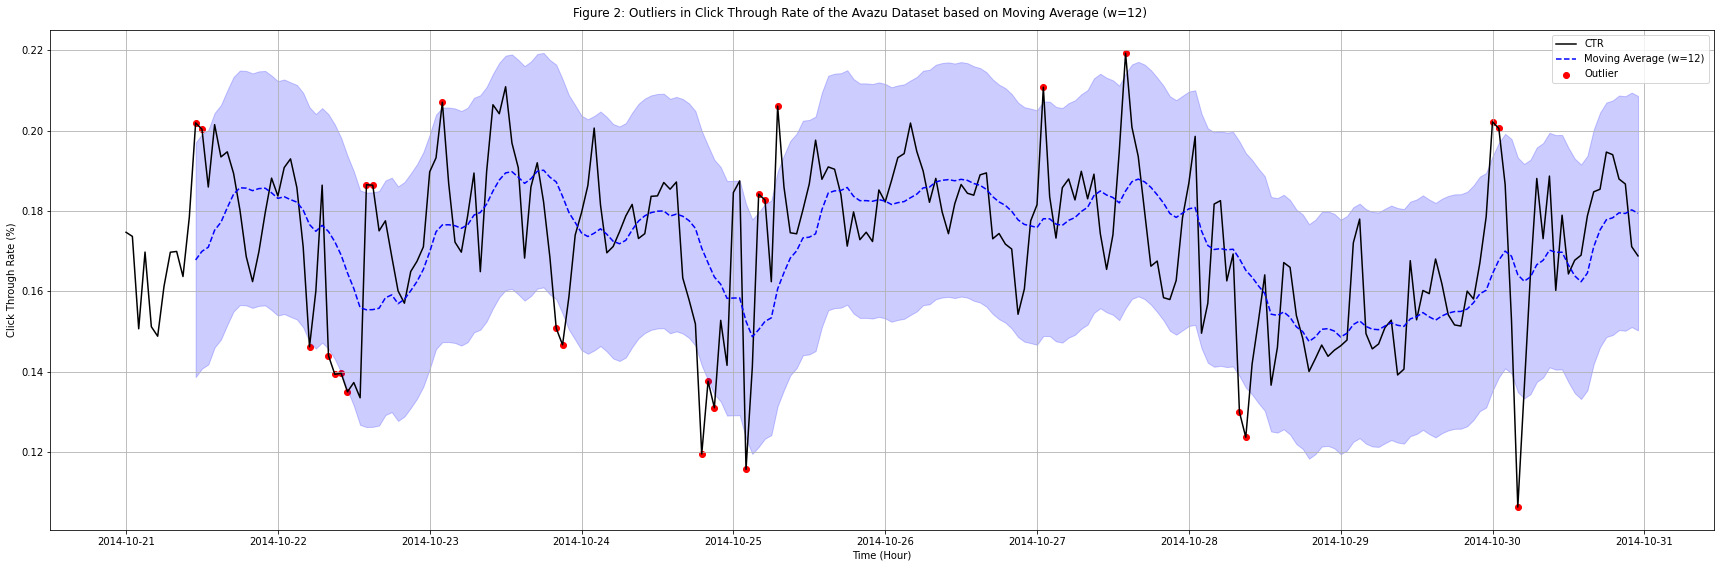

In [4]:
plt.figure(figsize=(24,8))
plt.suptitle(f'Figure 2: Outliers in Click Through Rate of the Avazu Dataset based on Moving Average (w={w})')
plt.plot(train_ctr.index, train_ctr, 'k')
plt.plot(ma.index, ma, 'b', linestyle='--')
plt.scatter(outliers.index, outliers, color='red')
plt.fill_between(ma.index, lower_bound, upper_bound, color='b', alpha=0.2)

plt.legend(('CTR', f'Moving Average (w={w})', 'Outlier'))
plt.xlabel('Time (Hour)')
plt.ylabel('Click Through Rate (%)')
plt.grid(True)
plt.tight_layout()

## 3. Future Improvements

In the above plot it can be seen that using the current assumptions the algorithm has identified some outliers in the time series data. However there were some points that were missed. For example the hill in between 2014-10-23 and 2014-10-24, when points on the same level (above 20%) have been identified in an earlier point of time. It is worth questioning a couple of assumptions of the model to see if another one would be more successful.

### 3.1 Data Distribution

First of all the model assumed a normal (Gaussian) distribution of the underlying process, which is worth visualizing - or even test the assumption using a Shapiro-Wilk test. Here I will rely on the prior (see the figure below). Based on the histogram of the CTR values (Figure 3, see below) it becomes clear that the calculated CTR values of the data are not normally distributed. Instead of a bell like shape the data is skewed towards the right end of the distribution. To aleviate this issue it is worth considering another moving method instead of the mean (ie.: median) - or use a different mean calculation than the arithmetic mean (ie.: geometric or harmonic mean) that is more appropriate for this distribution.

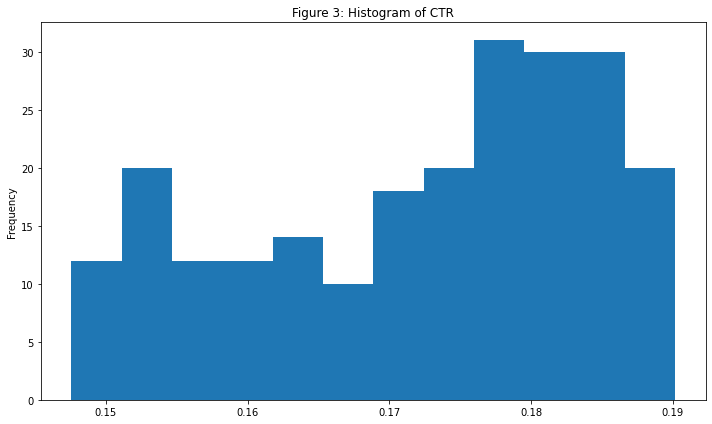

In [5]:
ma.plot.hist(bins=12, title='Figure 3: Histogram of CTR', figsize=(10,6))
plt.tight_layout()

### 3.2 Look ahead bias

Secondly, the algorithm uses the standard deviation of the entire dataset which creates a look ahead bias. Which means that decision is made on past data based on future information. This problem can be mitigated using the moving standard deviation.

### 3.3 Batch processing

This method is what is usually called a batch processing method. Which means that the outlier detection process requires more than the point considered to make a decision. In a setup where other systems rely on the output of the outlier detection system this might cause problems if there is high demand for the systems output (detecting fraudulent users) or the input for the system requires large amounts of data to be queried or loaded. A possible solution for this problem is to create a system that learned how to classify a point as an outlier based on past observations - for example a classifier trained on the output of the current solution.